In [74]:
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.coord as afwCoord
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.daf.persistence as dafPersist

In [75]:
# Plotting defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
zscale = ZScaleInterval()

In [5]:
butler = dafPersist.Butler('/home/shared/twinkles/output_data_v2')

In [76]:
subset = butler.subset('src')
dataid = subset.cache[4]
calexp = butler.get('calexp', dataId=dataid)
src = butler.get('src', dataId=dataid)
calib = calexp.getCalib()
wcs = calexp.getWcs()

In [73]:
#src.schema.getNames()
#len(src)
#for name in src.schema.getNames():
#    if "CircularApertureFlux" in name and name.endswith("_flux"):
#        print(name)
#count = 0
#for name in src.schema.getNames():
#    if "flag" in name:
#        count += 1
#print(count)

96


In [32]:
pixel_radius_names = ["3_0", "4_5", "6_0", "9_0", "12_0", "17_0", "25_0", "35_0", "50_0", "70_0"]
pixel_radius = np.array([float(x.replace('_', '.')) for x in pixel_radius_names])
#pixel_radius

In [45]:
fluxes = src.getPsfFlux()
good_indexes = fluxes > 0.0
fluxes_cleaned = fluxes[good_indexes]

In [46]:
psf_mag = calib.getMagnitude(fluxes_cleaned)
# Model fluxes must remove the same indexes that have negative real fluxes
cm_mag = calib.getMagnitude(src.getModelFlux()[good_indexes])
print(psf_mag.size, cm_mag.size)

2630 2630


In [48]:
extendedness = src['base_ClassificationExtendedness_value'][good_indexes]
extendedness.size

2630

In [109]:
#selection = src['calib_photometry_used']
#print(selection.size)
#calib.setThrowOnNegativeFlux(False)
#index = np.argmin(np.ma.masked_array(calib.getMagnitude(fluxes), ~selection))
#index
selection = src['calib_photometry_used'][good_indexes]
index = np.argmin(np.ma.masked_array(psf_mag, ~selection))
#index
#src['id'][good_indexes][index]

array([ True,  True,  True, ...,  True,  True,  True])

In [105]:
caf_schema_names = ["base_CircularApertureFlux_{}_flux".format(x) for x in pixel_radius_names]
caf_sigma_schema_names = ["base_CircularApertureFlux_{}_fluxSigma".format(x) for x in pixel_radius_names]
caf_flag_schema_names = ["base_CircularApertureFlux_{}_flag".format(x) for x in pixel_radius_names]
#caf_schema_names
ca_fluxes = np.array([src[name][index] for name in caf_schema_names])
ca_fluxSigmas = np.array([src[name][index] for name in caf_sigma_schema_names])
caf_flags = np.array([src[name][index] for name in caf_flag_schema_names])

In [106]:
good_fluxes = np.isfinite(ca_fluxes)

In [107]:
pixel_area = np.pi * pixel_radius**2
norm_ca_fluxes = ca_fluxes[good_fluxes] / pixel_area[good_fluxes]
#norm_ca_fluxes

(0, 38362.49061971808)

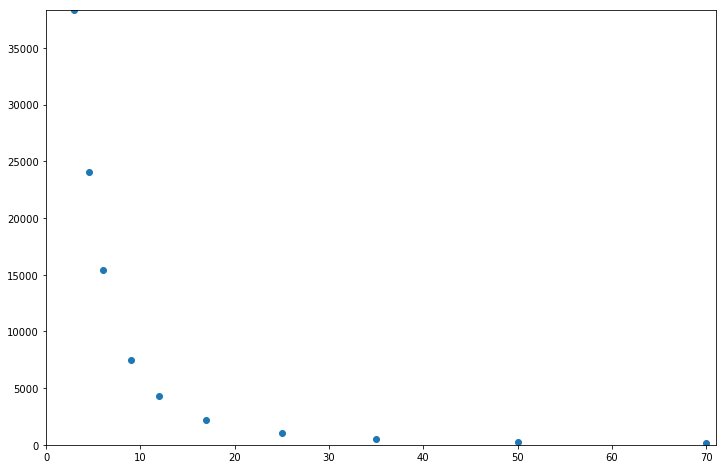

In [108]:
plt.figure()
plot_x = pixel_radius[good_fluxes]
plt.plot(plot_x, norm_ca_fluxes, 'o')
plt.xlim(0, np.max(plot_x) + 1)
plt.ylim(0, np.max(norm_ca_fluxes) + 10)

In [98]:
ra_target, dec_target = src['coord_ra'][index], src['coord_dec'][index] # Radians
radec = afwGeom.SpherePoint(ra_target, dec_target, afwGeom.radians)
cutoutSize = afwGeom.ExtentI(100, 100)
xy = afwGeom.PointI(wcs.skyToPixel(radec))
bbox = afwGeom.BoxI(xy - cutoutSize//2, cutoutSize)

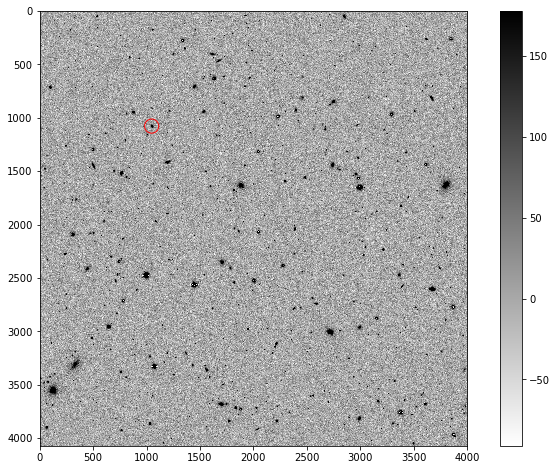

In [99]:
# Full frame image
image = butler.get('calexp', immediate=True, dataId=dataid)
vmin, vmax = zscale.get_limits(image.image.array)
plt.imshow(image.image.array, vmin=vmin, vmax=vmax, cmap='binary')
plt.colorbar()
#dir(xy)
plt.scatter(xy.getX(), xy.getY(), color='none', edgecolor='red', s=200)

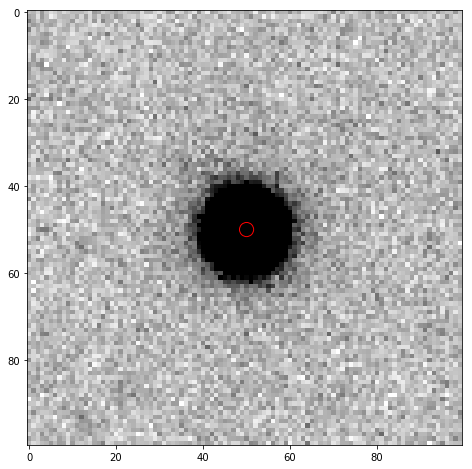

In [100]:
# Postage stamp image only
cutout_image = butler.get('calexp_sub', bbox=bbox, immediate=True, dataId=dataid).getMaskedImage()
vmin, vmax = zscale.get_limits(cutout_image.image.array)
plt.imshow(cutout_image.image.array, vmin=vmin, vmax=vmax, cmap='binary')

# Does the cutout_image have a wcs? It does not appear to...
plt.scatter(xy.getX() - cutout_image.getX0(), xy.getY() - cutout_image.getY0(),
            c='none', edgecolor='red', s=200)

(array([ 495.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1903.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

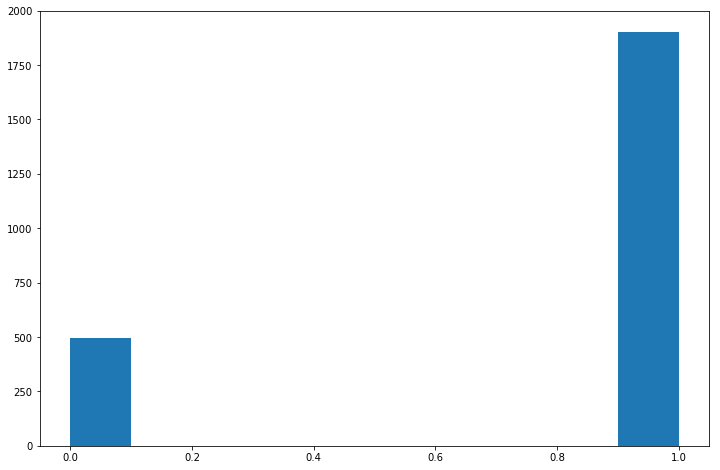

In [16]:
plt.figure()
plt.hist(extendedness_cleaned)